In [ ]:
import numpy as np
import glob
from scipy.optimize import curve_fit
import h5py
from natsort import natsorted,realsorted
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

: 

In [2]:
!pwd

/home/ab2935/project/purity-monitor


In [3]:
plt.style.use('style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
import sys
sys.path.insert(0, 'WaveformAnalysis/')

In [5]:
import Dataset as Dataset
import Waveform as Waveform
import SiPM as SiPM

In [6]:
import importlib
importlib.reload(Dataset)
importlib.reload(SiPM)
importlib.reload(Waveform)

<module 'Waveform' from 'WaveformAnalysis/Waveform.py'>

In [7]:
Path = '/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20220612/'

Let's get the voltage steps from the filenames

In [8]:
voltages = glob.glob(Path+'wave*')
voltages = [x.split('_')[-2] for x in voltages]
voltages = np.array(sorted([x.split('OV')[0] for x in voltages]))
voltages = np.unique(voltages)
# voltages=['3.50','4.00']
print(voltages)

['3.50' '4.00' '4.50' '5.00' '5.50' '6.00' '6.50' '7.00']


Now we can loop over all files for the various voltages, save the data and run a simple analysis including baseline subtraction and maximum finding

In [9]:
def line(x,a,b):
    return a*x+b

In [10]:
def rebin(hx,h,bins):
    h_rebin=[]
    for i in range(int(len(h)/bins)):
        start_idx=i*bins
        end_idx=(i+1)*bins
        h_rebin.append(np.sum(h[start_idx:end_idx]))
    hx_rebin=range(len(h_rebin))
    return np.array(hx_rebin), np.array(h_rebin)

In [11]:
def gauss(x,a,mu,sigma):
    return (a*np.exp(-0.5*((x-mu)/sigma)**2))

In [12]:
def line_gain(x,m,c):
    return (m*x)+c

In [13]:
def gain_calculator(PATH):
    BINS=20 #Number of bins to rebin the MCA data with
    N_peaks= 4# Number o peaks to use for calculating the gain
    gain_list=[] #empty list to fill in the values of gain, returned at the end of this function
    gain_err=[] #empty list to fill in the values of gain fit error, returned at the end of this function
    Files = glob.glob(PATH+'mca_*.h5')
    #for loop to loop over all the files
    for i,file in enumerate(natsorted(Files)): 
    
    
        f = h5py.File(file, 'r')  
        ch2 = f.get('ch2')
        for key in ch2.keys(): 
            df = np.array(ch2.get(key))
        h = df
        hx = np.arange(0,len(h),1)
        hx,h = rebin(hx,h, BINS)

        gain_temp=[]#reset the gain temp list here to store gain values for one file
        #Use scipy find_peaks to find peaks starting with a very high prominence 
        PROMINENCE=1000 #This prominence is re-set here to ensure that every file starts out with a high prominence
        peaks,pdict=find_peaks(h,prominence=PROMINENCE,width=50)
        peak_length=len(peaks)
        #We want to ensure that using a high prominence gives us at least 3 peaks to fit a straight line to. If it doesn't we reduce prominence till we get at least 3 peaks. N_peaks is set above
        while (peak_length<N_peaks+1):
            PROMINENCE=PROMINENCE-1
            peaks,pdict=find_peaks(h,prominence=PROMINENCE,width=10)
            peak_length=len(peaks)
        
        #To avoid fitting the pedestal, we ignore the first peak. In case the pedestal isn't there, then first peak gets ignored. This shouldn't change gain or BV calculation
        first_pe_max=hx[peaks[1]] # The x-value of the 2nd peak.Index=1 means the second peak will be used for getting fit parameters
        max_value=h[peaks[1]] # The height of the 2nd peak
        x_idx_array=(h<0.5*max_value) & (hx>first_pe_max)# returns a boolean array where both conditions are true
        right_side_x= hx[np.where(x_idx_array)[0][0]] #finding the first time where x_idx_array is True
        sigma_guess=np.abs(first_pe_max-right_side_x) #We need this to fit the width of the Gaussian peaks

        plt.figure(figsize=(12,5)) # Call the figure here
        plt.subplot(1,2,1) #This subplot will plot the position of the peaks and also the data
        plt.yscale('log')
        plt.plot(hx[peaks],h[peaks],'*') # plot the peak markers
        plt.step(hx,h,lw=1) #plot the signal
        cut= (hx < first_pe_max+sigma_guess) & (hx > first_pe_max-sigma_guess) # This cut helps to fix the width of the peak-fit
        popt,pcov=curve_fit(gauss,hx[cut],h[cut],p0=[max_value,first_pe_max,sigma_guess]) # We use curve_fit to return the optimal parameters and the covariance matrix
        plt.plot(hx[cut],gauss(hx[cut],*popt),color='green',label='Fit',lw=2,alpha=0.5) # Here we plot the fit on the 2nd peak to see if everything looks ok.
        for i,peak in enumerate(peaks[1:]): #here we ignore the first peak because it could be the pedestal
            new_first_pe_max=hx[peak] #x-value of the peak
            new_max_value=h[peak] #height of the peak
            new_x_idx_array=(h<0.5*new_max_value) & (hx>new_first_pe_max) # returns a boolean array where both conditions are true
            new_right_side_x= hx[np.where(new_x_idx_array)[0][0]] #finding the first time where x_idx_array is True
            new_sigma_guess=np.abs(new_first_pe_max-new_right_side_x) #We need this to fit the width of the Gaussian peaks


            new_cut= (hx < new_first_pe_max+new_sigma_guess) & (hx > new_first_pe_max-new_sigma_guess) # This cut helps to fix the width of the peak-fit
            popt_new,pcov_new=curve_fit(gauss,hx[new_cut],h[new_cut],p0=[new_max_value,new_first_pe_max,new_sigma_guess],maxfev=100000) # We use curve_fit to return the optimal parameters and the covariance matrix
            plt.plot(hx[new_cut],gauss(hx[new_cut],*popt_new),color='r',label='Fit',lw=3) # Here we plot the fit on all the peaks
            gain_temp.append(popt_new[1]) #Here we append the value of the peak fit mean 
        plt.subplot(1,2,2) #This subplot shows the straight line fit to the peak means to obtain the slope/gain
        popt_temp,pcov_temp=curve_fit(line_gain,np.arange(1,len(peaks)),gain_temp,p0=[90,5],maxfev=10000) #Use the straight line fit here
        plt.plot(np.arange(1,len(peaks)),line_gain(np.arange(1,len(peaks)),*popt_temp),color='k',label=(str(np.round(popt_temp[0],2)))+'$\pm$'+str(np.round(np.sqrt(np.diag(pcov_temp))[0],2))+' ADC/PE') # plot the straight line fit
        plt.scatter(np.arange(1,len(peaks)),gain_temp,color='r') #plot the values of the peak means
        plt.legend(loc=2)
        plt.show() #show the plot
        gain_list.append(popt_temp[0]) #append the gain values to obtain BV later
        gain_err.append(np.sqrt(np.diag(pcov_temp))[0]) #append the straight line error fit 
    return(np.array(gain_list),np.array(gain_err))

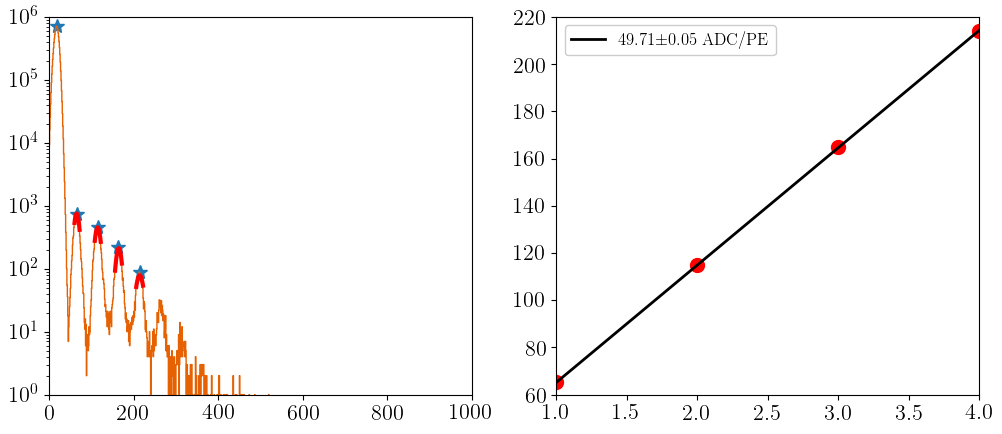

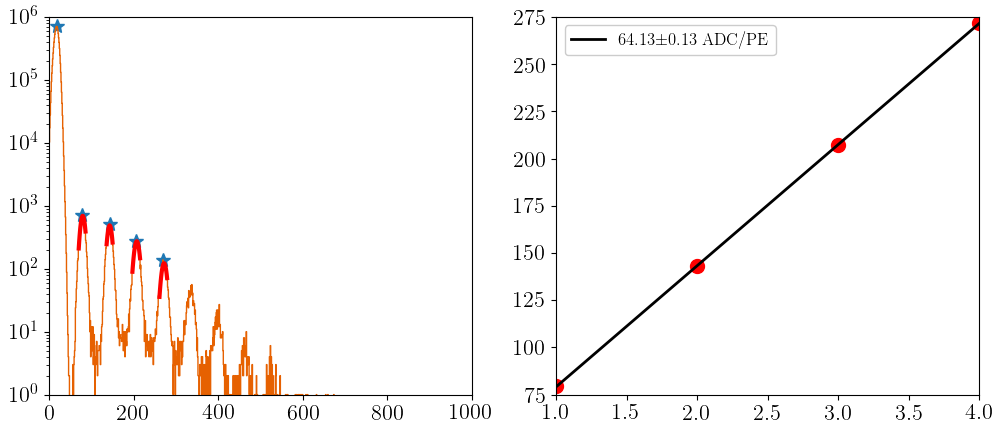

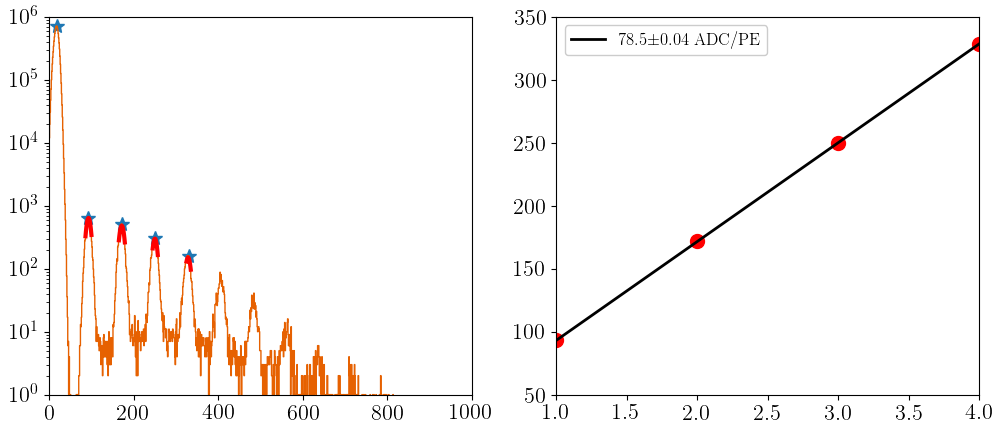

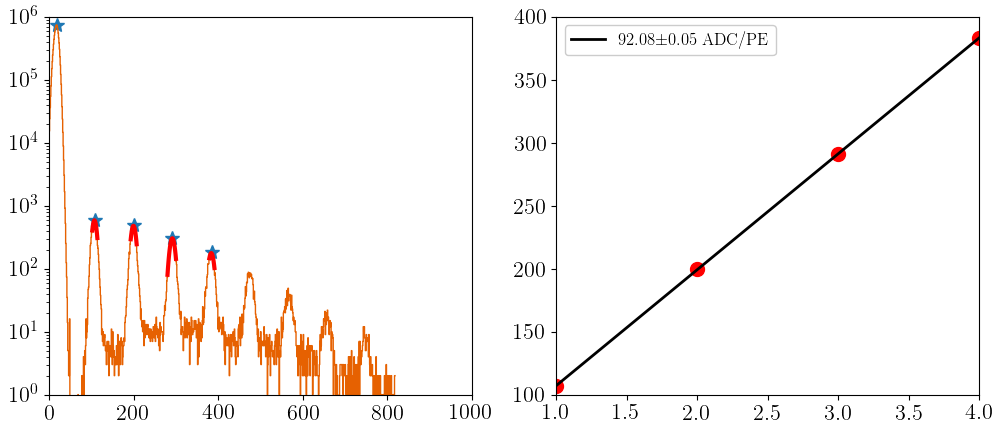

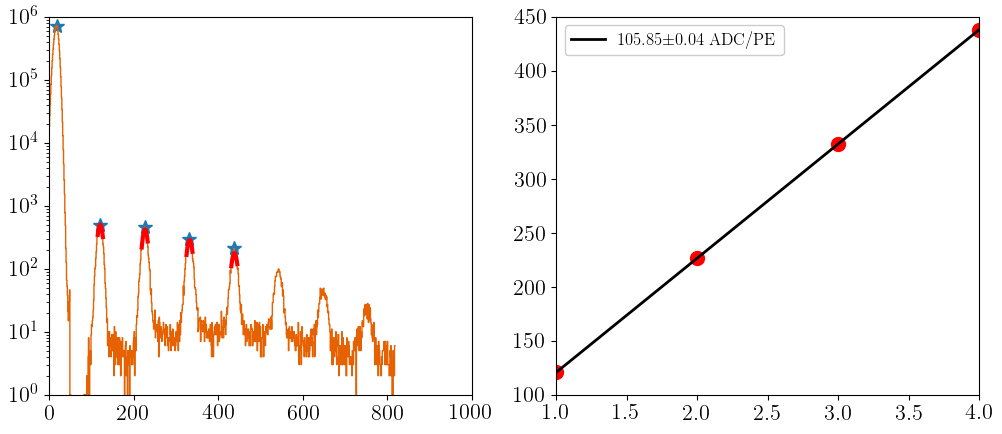

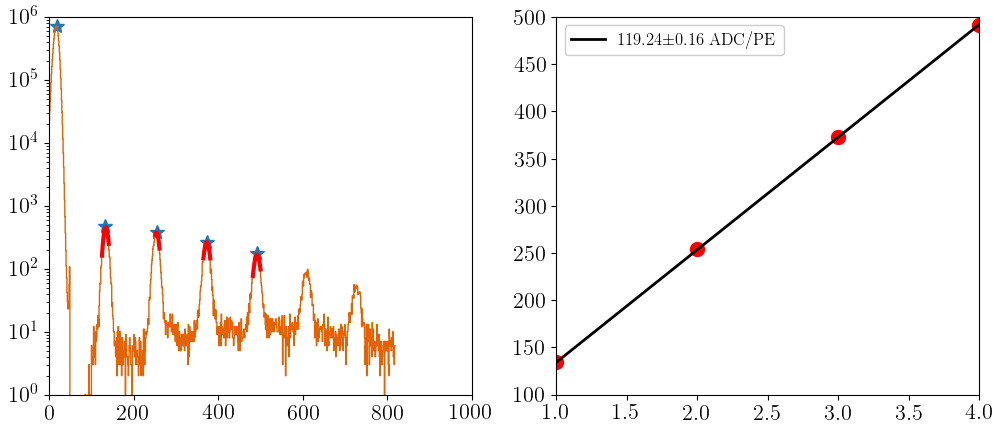

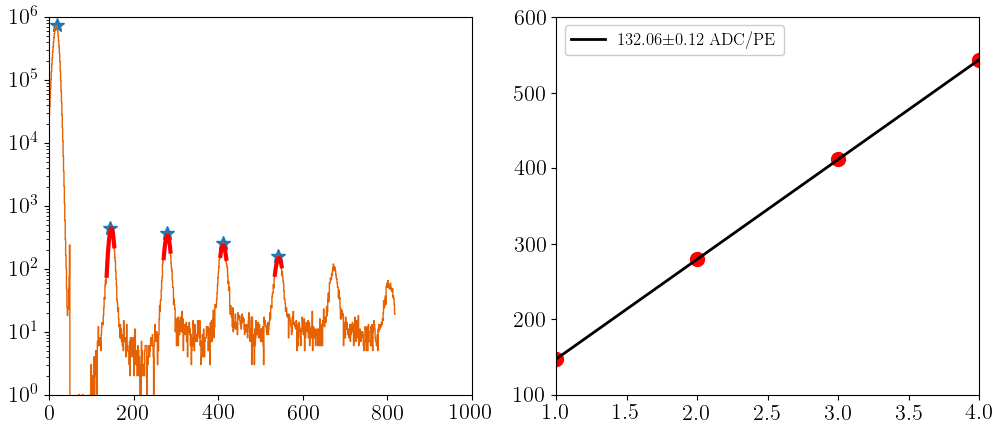

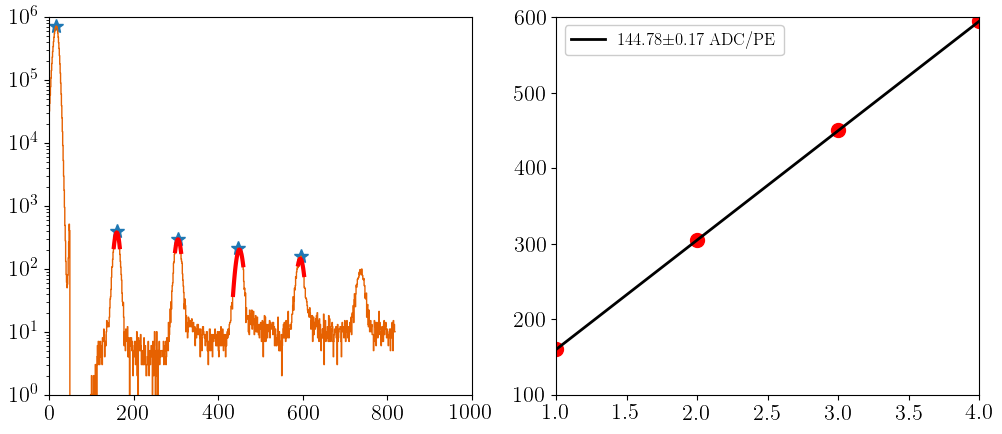

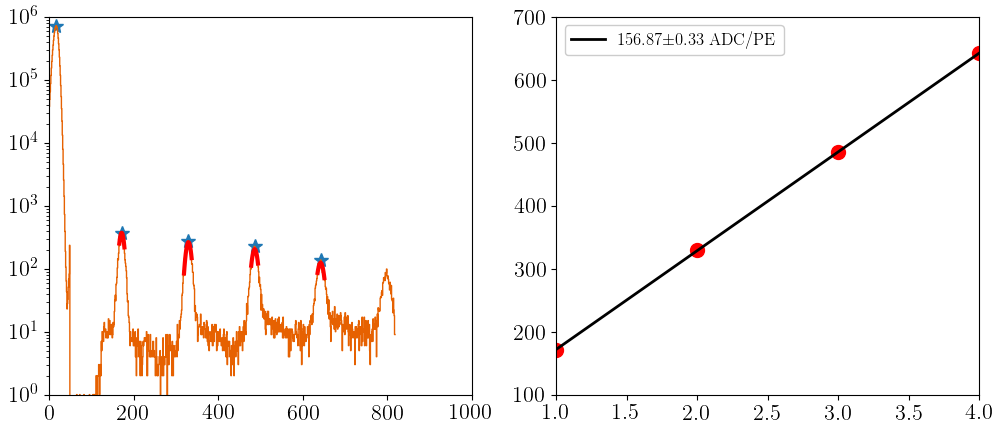

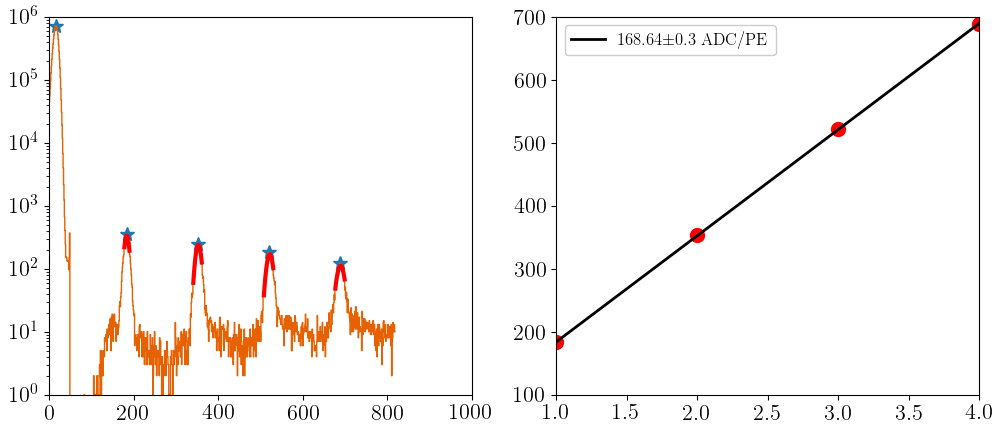

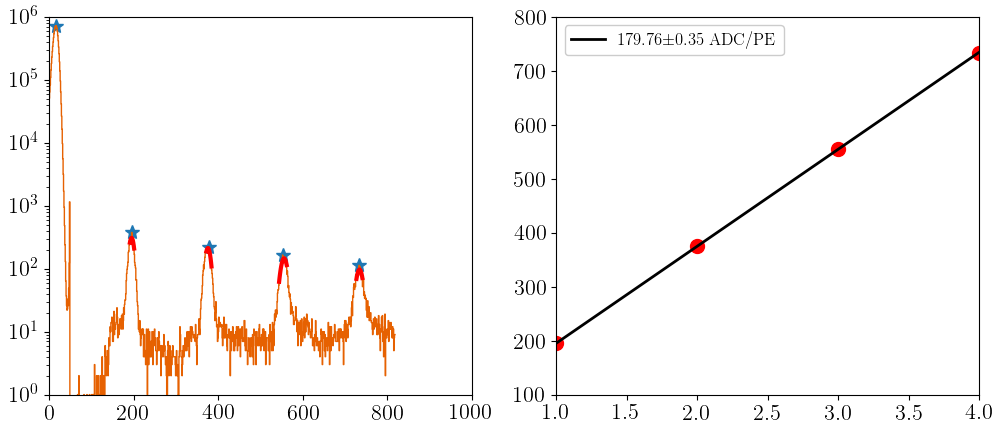

In [14]:
Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20220609/'
gain_list_0V,gain_err_0V=gain_calculator(Path)

In [ ]:
def line(x,a,b):
    return a*(x-b)

volts = voltages.astype(float) + 27.5
x_data=np.arange(np.min(volts),np.max(volts)+0.1,1)
plt.errorbar(volts,gain_list_0V,yerr=gain_err_0V,label='Data',fmt='o',ms=5)

popt_0,pcov_0=curve_fit(line,volts,gain_list_0V,p0=[31,27],sigma=gain_err_0V)
label = 'BV= '+str(np.round(popt_0[1],2))+ '$\pm$'+ str(np.round(np.sqrt(np.diag(pcov_0)[1]),2))+' V'
plt.plot(x_data, line(x_data,*popt_0), color=colors[1], ls='--', label=label)
# plt.plot(x_data,line(x_data,*popt_260),color=colors[1],label='BV= '+str(np.round(popt_260[1],2))+ '$\pm$'+ str(np.round(np.sqrt(np.diag(pcov_260)[1]),2))+' V',ls='--')
plt.ylabel('Gain (ADC/PE)')
plt.xlabel('Bias Voltage (V)')
plt.legend(loc=2)
plt.savefig('BV_comparison.pdf')
plt.show()

In [17]:
Path = '/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20220612/'
Ds = {}
N_peaks= 4
for volt in voltages: 
    Ds[volt] = SiPM.SiPM(Path=Path, Selection='wavefms_keith_{}OV*.h5'.format(volt))
    Ds[volt].Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]
    
    for File in natsorted(Ds[volt].Files):
        max_amp_all_st=[]
        # print(File)
        Ds[volt].ImportDataFromHDF5(File, Ds[volt].Ch, var=[])
        Ds[volt].get_sampling()
        Ds[volt].sampling_freq
        Ds[volt].shaping_time=[2e-6,5e-6,10e-6] #List of shaping times to shape the signal with
        Ds[volt].setup_butter_filter() # calculate the butterworth filter coefficients 
        for waveform in Ds[volt].Ch[0].Amp: #loop over the waveforms inside the file
        # print(waveform)
            y=Ds[volt].get_filtered_waveform(waveform) # return the filtered waveform
            # plt.plot(Ds[volt].Ch[0].Time,waveform,color='k',label='data')

            max_amp,max_T=Ds[volt].Ch[0].GetAllMaxima(y)
            max_amp_all_st.append(max_amp)
            # plt.plot(max_T,max_amp,'r*')  
            # for i,y1 in enumerate(y):
                # plt.plot(Ds[volt].Ch[0].Time,y1,color=colors[i])
            # plt.xlim(180,225)
    
    sh_2mu=[]
    sh_5mu=[]
    sh_10mu=[]

    for value in max_amp_all_st:
        sh_2mu.append(value[0])
        sh_5mu.append(value[1])
        sh_10mu.append(value[2])
    sh_2mu=np.array(sh_2mu)
    sh_5mu=np.array(sh_5mu)
    sh_10mu=np.array(sh_10mu)
    plt.figure(figsize=(6,4))
    BINS=np.linspace(0,800,500)
    
    # plt.hist(sh_5mu.flatten(),histtype='step',bins=BINS,label='5$\mu$s')
    # plt.hist(sh_10mu.flatten(),histtype='step',bins=BINS,label='10$\mu$s')


    h,hx=np.histogram(sh_2mu.flatten(),bins=BINS)
    plt.step(hx[:-1],h,lw=2,label='2$\mu$s')
    gain_temp=[]#reset the gain temp list here to store gain values for one file
    #     #Use scipy find_peaks to find peaks starting with a very high prominence 
    PROMINENCE=500 #This prominence is re-set here to ensure that every file starts out with a high prominence
    peaks,pdict=find_peaks(h,prominence=PROMINENCE,width=50)
    peak_length=len(peaks)
    #     #We want to ensure that using a high prominence gives us at least 3 peaks to fit a straight line to. If it doesn't we reduce prominence till we get at least 3 peaks. N_peaks is set above
    while (peak_length<N_peaks+1):
        PROMINENCE=PROMINENCE-1
        peaks,pdict=find_peaks(h,prominence=PROMINENCE,width=10)
        peak_length=len(peaks)
        
    # #To avoid fitting the pedestal, we ignore the first peak. In case the pedestal isn't there, then first peak gets ignored. This shouldn't change gain or BV calculation
    first_pe_max=hx[peaks[1]] # The x-value of the 2nd peak.Index=1 means the second peak will be used for getting fit parameters
    max_value=h[peaks[1]] # The height of the 2nd peak
    x_idx_array=(h<0.5*max_value) & (hx>first_pe_max)# returns a boolean array where both conditions are true
    right_side_x= hx[np.where(x_idx_array)[0][0]] #finding the first time where x_idx_array is True
    sigma_guess=np.abs(first_pe_max-right_side_x) #We need this to fit the width of the Gaussian peaks

    plt.legend(loc='best')
    plt.title("OV= "+volt+" V")
    plt.xlabel('Voltage (mV)')
    plt.ylabel('Counts')
    plt.show()


#8 voltages
#10 files per voltage
#100 waveforms per file
#3 max amp values for the 3 filters per waveform
